In [55]:
%matplotlib inline

import os
import sys
import time

import SimpleITK as sitk
import numpy as np
import csv
from glob import glob
import pandas as pd
from skimage import measure
from skimage import transform
from scipy import ndimage
from scipy import stats
from matplotlib import pyplot as plt
import tensorflow as tf
from keras.models import Model

import util
import image_aug
import luna_util
import luna_cropper
import luna_preprocess
import luna_enhance
import luna_train_util
import luna_unet_data5
import luna_train_unet5

reload(util);
reload(image_aug);
reload(luna_util);
reload(luna_cropper);
reload(luna_preprocess);
reload(luna_enhance);
reload(luna_train_util);
reload(luna_unet_data5);
reload(luna_train_unet5);

In [82]:
nodule_mask_labels = measure.label(nodule_mask)

In [83]:
regions = measure.regionprops(nodule_mask_labels)

510


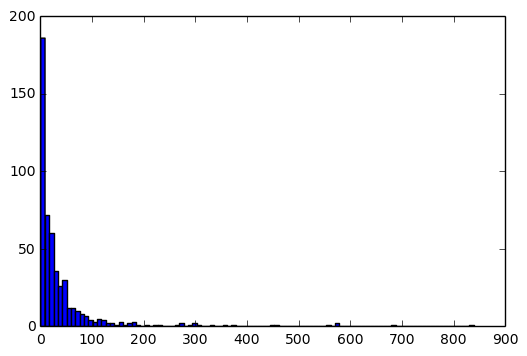

In [86]:
zs = []
areas = []
new_regions = []
for r in regions:
    if True: # r.area >= (4.0/3*np.pi*(3.0/2)**3) and all(np.array(r.filled_image.shape)>1):
        zs.append((r.bbox[0]+r.bbox[3])//2)
        areas.append(r.area)
        new_regions.append(r)
print len(areas)
plt.hist(areas, bins=100);

839
124
104


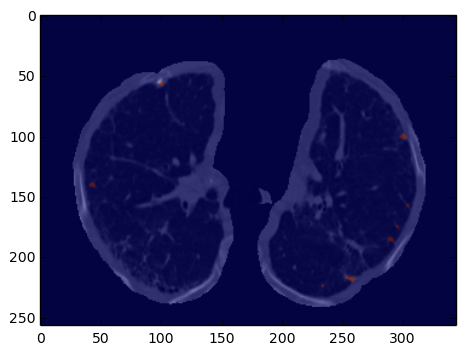

In [87]:
#z = zs[np.random.randint(len(zs))]
print np.max(areas)
print np.argmax(areas)
z = zs[np.argmax(areas)]
print np.sum(nodule_mask[z])
plot_image_and_mask(masked_lung[z], nodule_mask[z])

In [68]:
def extract_features(region):
    reg = region
    nod = reg.filled_image
    f = [reg.area]
    for axis in range(3):
        view = np.rollaxis(nod, axis)
        tnod = view[np.argmax(np.sum(view, axis=(1,2)))]
        treg = measure.regionprops(tnod.astype(int))[0]
        f.extend([
            treg.area,
            treg.eccentricity,
            treg.equivalent_diameter,
            treg.perimeter,
            treg.solidity
        ])
    return f

In [213]:
f = []
for i, r in enumerate(new_regions):
    f.append(extract_features(r))

In [163]:
x = measure.regionprops(nod[:,9,:].astype(int))[0]
for p in x:
    print p, x[p]

area 104
bbox (1L, 0L, 8L, 18L)
centroid (4.1730769230769234, 8.9038461538461533)
convex_area 111
convex_image [[False False False  True  True  True  True  True  True  True  True  True
   True  True False False False False]
 [False  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True False]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True]
 [False  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True]
 [False  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True]
 [False False False  True  True  True  True  True  True  True  True  True
   True  True  True  True  True False]]
coords [[ 1  4]
 [ 1  5]
 [ 1  6]
 [ 1  7]
 [ 1  8]
 [ 1  9]
 [ 1 10]
 [ 2  1]
 [ 2  2]
 [ 2  3]


In [51]:
from keras.layers import merge, Input

In [52]:
tensor_a = Input(shape=(32,))
tensor_b = Input(shape=(32,))
merged_tensor = merge([tensor_a, tensor_b], mode='concat', concat_axis=1)

In [54]:
merged_tensor.get_shape()

TensorShape([Dimension(None), Dimension(64)])

In [56]:
with tf.device('/cpu:0'):
    model = luna_train_unet5.get_unet()
# model.load_weights('./unet5.hdf5')
model.load_weights('./save/unet5-ex.hdf5-gpu-epoch-50-0p67')

In [57]:
utip_model = Model(input=model.input,
                   output=model.get_layer(name='utip').output)
#intermediate_output = intermediate_layer_model.predict(data)

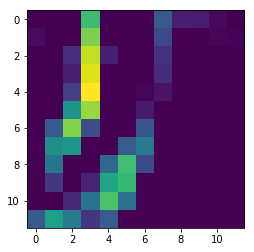

In [66]:
plt.imshow(utip_model.predict(np.reshape(image, [1, 1] + list(image.shape)))[0,6])

In [24]:
images, masks = luna_train_unet5.load_data(['subset9'], ex_percent=1.0)

3419


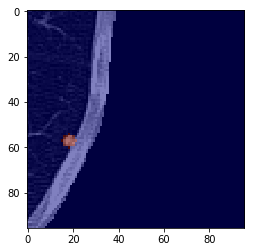

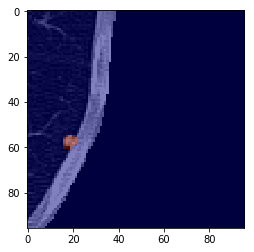

In [27]:
idx = np.random.randint(len(images))
print idx
image, mask = images[idx,0], masks[idx,0]
p_mask = model.predict(np.reshape(image, [1, 1] + list(image.shape)))[0,0]
plot_image_and_mask(image, mask)
plot_image_and_mask(image, util.to_bool_mask(p_mask))

In [26]:
def sample_with_min_num_nodules(min_num_nodules, annt_df, subset):
    if subset is not None:
        annt_df = annt_df[annt_df.file.str.contains(subset)]
    t = annt_df.groupby('file').count()
    t = list(t[t.seriesuid>=min_num_nodules].index)
    f = t[np.random.randint(len(t))]
    f_id = luna_preprocess.get_file_id(f)
    return f_id, annt_df[annt_df.file==f]
    

def plot_image_and_mask(image, mask):
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, cmap='jet', alpha=0.5)
    plt.show()

    
def rand_slice_image(masked_lung, all_nodule_mask):
    image, mask = luna_util.slice_image(
        masked_lung, all_nodule_mask, np.random.randint(len(masked_lung)))
    return image, mask


def slice_image_with_nodule(masked_lung, all_nodule_mask, nodule, offset=0):
    nod_v_x, nod_v_y, nod_v_z, nod_v_d = nodule
    image, mask = luna_util.slice_image(
        masked_lung, all_nodule_mask, nod_v_z+offset)
    return image, mask


def pred_nodule_mask(image, model, debug=False):
    size = 96
    csize = size // 2
    pad = (size - csize) // 2
    ans = np.zeros_like(image, dtype=np.float)
    nrows, ncols = np.ceil((np.asarray(image.shape) / csize)).astype(np.int)
    for i in range(nrows):
        for j in range(ncols):
            row_slice = slice(i * csize, (i + 1) * csize)
            col_slice = slice(j * csize, (j + 1) * csize)
            crop_yx = [csize * i - pad, csize * j - pad]
            image_patch = image_aug.crop(image, crop_yx, [size, size])
            mask_patch = model.predict(
                np.reshape(image_patch, [1, 1, size, size]))[0,0]
            ans[row_slice, col_slice] += mask_patch[pad:pad+csize, pad:pad+csize]
            if debug:
                plt.figure()
                plot_image_and_mask(image_patch, mask_patch)
                plt.show()
    return ans

In [68]:
file_list = luna_preprocess.get_file_list()
file_dict = luna_preprocess.get_file_dict(file_list)
annt_df = luna_preprocess.get_annt_df(file_dict)

In [69]:
f_id, f_annt = sample_with_min_num_nodules(1, annt_df, 'subset9')
print f_id

1.3.6.1.4.1.14519.5.2.1.6279.6001.229860476925100292554329427970


In [70]:
image = luna_preprocess.Image()
image.load(f_id)
masked_lung = image.masked_lung
all_nodule_mask = image._all_nodule_mask
nodules = image.get_v_nodules()
print '# of nodules = %d'%len(nodules)

# of nodules = 3


In [74]:
t_image, t_nodule_mask = slice_image_with_nodule(
    masked_lung, all_nodule_mask, nodules[0])
p_nodule_mask = pred_nodule_mask(t_image, model, False)
print luna_train_util.dice_coef_np(t_nodule_mask, p_nodule_mask)

0.278383230986


In [10]:
t_image, t_nodule_mask = rand_slice_image(masked_lung, all_nodule_mask)
p_nodule_mask = pred_nodule_mask(t_image, model, False)
print luna_train_util.dice_coef_np(t_nodule_mask, p_nodule_mask)

0.057116697003


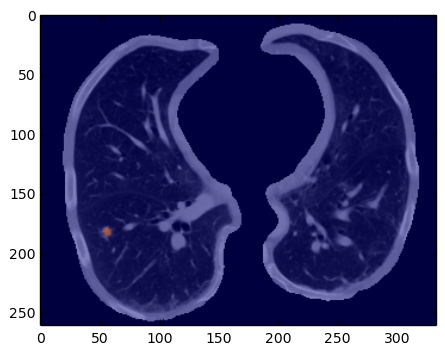

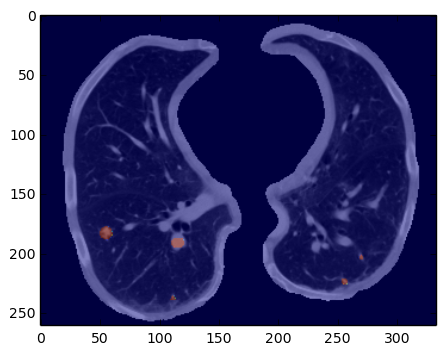

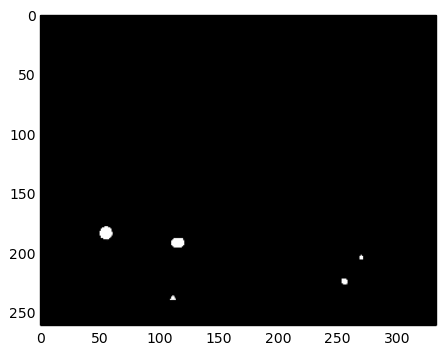

In [13]:
plt.figure()
plot_image_and_mask(t_image, t_nodule_mask)
plt.figure()
plot_image_and_mask(t_image, p_nodule_mask)
plt.figure()
plt.imshow(p_nodule_mask, cmap='gray')